In [3]:
import numpy as np
import numbers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
def conv_layer(input_tensor, filters, kernel_size, strides, padding, activation, normalization, dropout_rate):
    
    x = layers.Conv2D(filters = filters, kernel_size = kernel_size, strides=strides,\
                      padding=padding, activation=activation)(input_tensor)
    
    if normalization == 'batch':
        x = layers.BatchNormalization()(x)
    if normalization == 'layer':
        x = layers.LayerNormalization()(x)
    
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
        
    return x

def dense_layer(input_tensor, units, activation, normalization, dropout_rate):
    
    x = layers.Dense(units=units, activation=activation)(input_tensor)
    
    if normalization == 'batch':
        x = layers.BatchNormalization()(x)
    if normalization == 'layer':
        x = layers.LayerNormalization()(x)
    
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
        
    return x

In [166]:
def single_image_simple_model(input_shape, classes, optimizer, \
                                 conv_normalization = None, dense_normalization = None, \
                                 conv_dropout=0, dense_dropout=0):
    conv_layer_count = 5
    if isinstance(conv_dropout, numbers.Number):
        conv_dropout = [conv_dropout] * conv_layer_count
    
    dense_layer_count = 2
    if isinstance(dense_dropout, numbers.Number):
        dense_dropout = [dense_dropout] * dense_layer_count
    
    image_input = keras.Input(shape=input_shape)
    
    x = conv_layer(image_input, 24, (5,5), (2,2), 'valid', 'relu', conv_normalization, conv_dropout[0])
    x = conv_layer(x, 32, (5,5), (2,2), 'valid', 'relu', conv_normalization, conv_dropout[1])
    x = conv_layer(x, 48, (3,3), (2,2), 'valid', 'relu', conv_normalization, conv_dropout[2])
    x = conv_layer(x, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization, conv_dropout[3])
    x = conv_layer(x, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization, conv_dropout[4])
    
    x = layers.Flatten()(x)
    
    x = dense_layer(x, 128, 'relu', dense_normalization, dense_dropout[0])
    x = dense_layer(x, 64, 'relu', dense_normalization, dense_dropout[1])
    
    output = layers.Dense(units=classes, activation='sigmoid')(x)
    
    model = keras.Model(inputs=image_input, outputs=output, name="single_image_simple_model")
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    
    return model

In [167]:
model = single_image_simple_model((299,299,1), 6, 'adam', 'batch', 'layer', [0.2,0,0,0,0], 0.4)
model.summary()

Model: "single_image_simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_210 (InputLayer)       [(None, 299, 299, 1)]     0         
_________________________________________________________________
conv2d_701 (Conv2D)          (None, 148, 148, 24)      624       
_________________________________________________________________
batch_normalization_74 (Batc (None, 148, 148, 24)      96        
_________________________________________________________________
dropout_89 (Dropout)         (None, 148, 148, 24)      0         
_________________________________________________________________
conv2d_702 (Conv2D)          (None, 72, 72, 32)        19232     
_________________________________________________________________
batch_normalization_75 (Batc (None, 72, 72, 32)        128       
_________________________________________________________________
conv2d_703 (Conv2D)          (None, 35, 3

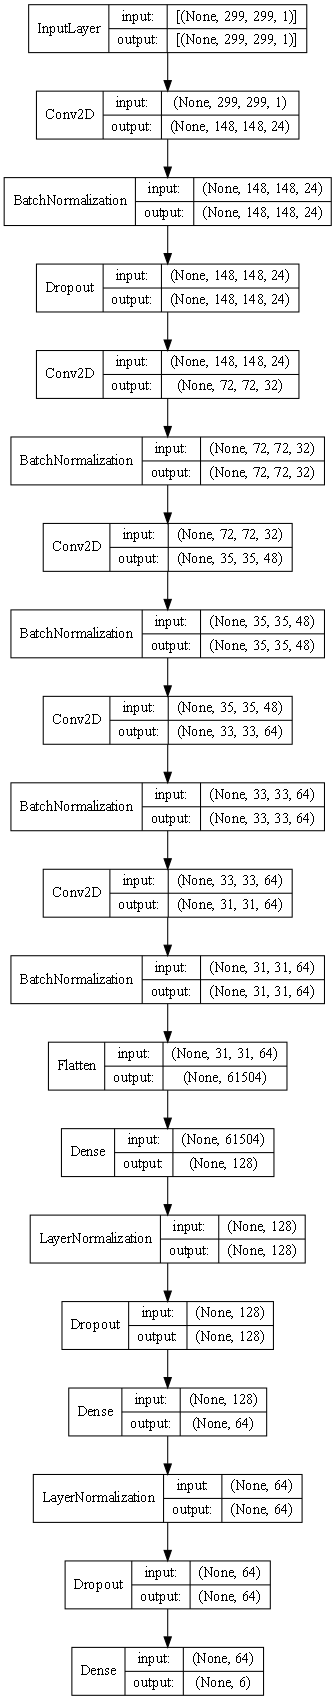

In [83]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir="TB", expand_nested=False, dpi=75)

In [84]:
def duel_image_add_conv_model(input_shape, classes, optimizer, \
                                 conv_normalization_im1 = None, conv_normalization_im2 = None, \
                                 conv_normalization_cmb = None, dense_normalization = None, \
                                 conv_dropout_im1=0, conv_dropout_im2=0, conv_dropout_cmb=0, dense_dropout=0):
    conv_layer_count_im1 = 4
    if isinstance(conv_dropout_im1, numbers.Number):
        conv_dropout_im1 = [conv_dropout_im1] * conv_layer_count_im1
    
    conv_layer_count_im2 = 2
    if isinstance(conv_dropout_im2, numbers.Number):
        conv_dropout_im2 = [conv_dropout_im2] * conv_layer_count_im2
    
    conv_layer_count_cmb = 1
    if isinstance(conv_dropout_cmb, numbers.Number):
        conv_dropout_cmb = [conv_dropout_cmb] * conv_layer_count_cmb
    
    dense_layer_count = 2
    if isinstance(dense_dropout, numbers.Number):
        dense_dropout = [dense_dropout] * dense_layer_count
    
    image_input = keras.Input(shape=input_shape)
    
    x_1 = conv_layer(image_input, 24, (5,5), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[0])
    x_1 = conv_layer(x_1, 36, (5,5), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[1])
    x_1 = conv_layer(x_1, 48, (3,3), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[2])
    x_1 = conv_layer(x_1, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[3])
    
    second_image_shape = np.append(np.array(x_1.shape[1:3]) + 4, 1)
    second_image_input = keras.Input(shape=second_image_shape)
    print(f'Second Image Size should be: {second_image_shape}')
    
    x_2 = conv_layer(second_image_input, 32, (3,3), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[0])
    x_2 = conv_layer(x_2, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[1])
    
    x = tf.keras.layers.Add()([x_1, x_2])
    
    x = conv_layer(x, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_cmb, conv_dropout_cmb[0])
    
    x = layers.Flatten()(x)
    
    x = dense_layer(x, 128, 'relu', dense_normalization, dense_dropout[0])
    x = dense_layer(x, 64, 'relu', dense_normalization, dense_dropout[1])
    
    output = layers.Dense(units=classes, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[image_input, second_image_input], outputs=output, name="duel_image_add_conv_model")
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    
    return model

Second Image Size should be: [37 37  1]


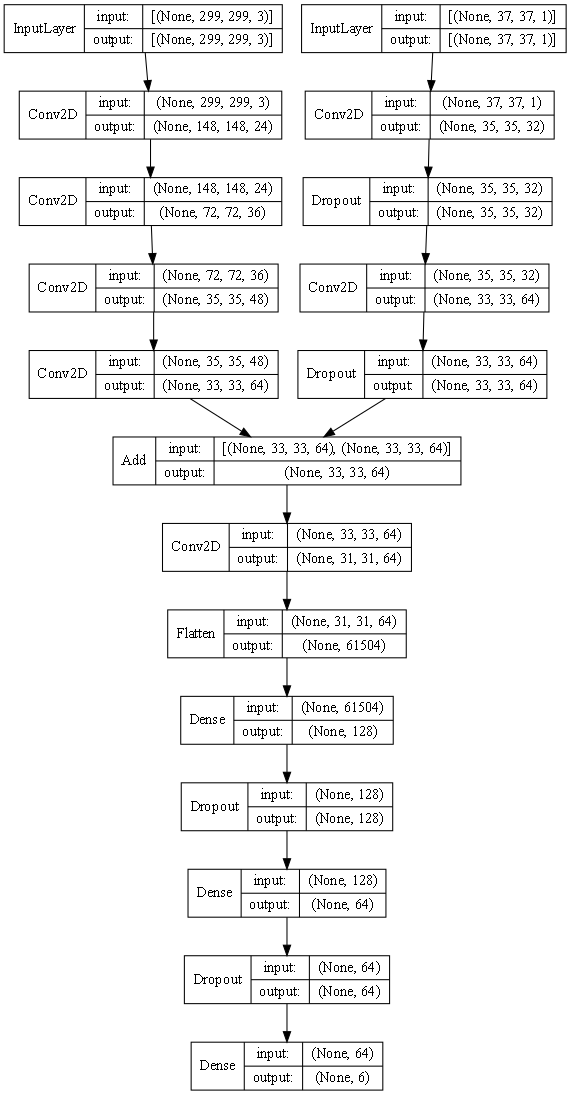

In [119]:
model = duel_image_add_conv_model((299,299,3), 6, 'adam', conv_dropout_im2=[0.2, 0.2], dense_dropout=0.2)
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir="TB", expand_nested=True, dpi=75)

In [86]:
model.summary()

Model: "duel_image_add_conv_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           [(None, 37, 37, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_234 (Conv2D)             (None, 148, 148, 24) 1824        input_71[0][0]                   
__________________________________________________________________________________________________
conv2d_238 (Conv2D)             (None, 35, 35, 32)   320         input_72[0][0]                   
__________________________________________________________________________

In [92]:
def duel_image_add_dense_model(input_shape_im1, input_shape_im2, classes, optimizer, \
                                 conv_normalization_im1 = None, conv_normalization_im2 = None, \
                                 dense_normalization_im1 = None, dense_normalization_im2 = None, \
                                 dense_normalization_cmb = None, conv_dropout_im1=0, conv_dropout_im2=0, \
                                 dense_dropout_im1=0, dense_dropout_im2=0, dense_dropout_cmb=0):
    conv_layer_count_im1 = 5
    if isinstance(conv_dropout_im1, numbers.Number):
        conv_dropout_im1 = [conv_dropout_im1] * conv_layer_count_im1
    
    conv_layer_count_im2 = 3
    if isinstance(conv_dropout_im2, numbers.Number):
        conv_dropout_im2 = [conv_dropout_im2] * conv_layer_count_im2
    
    dense_layer_count_im1 = 2
    if isinstance(dense_dropout_im1, numbers.Number):
        dense_dropout_im1 = [dense_dropout_im1] * dense_layer_count_im1
    
    dense_layer_count_im2 = 1
    if isinstance(dense_dropout_im2, numbers.Number):
        dense_dropout_im2 = [dense_dropout_im2] * dense_layer_count_im2
        
    dense_layer_count_cmb = 1
    if isinstance(dense_dropout_cmb, numbers.Number):
        dense_dropout_cmb = [dense_dropout_cmb] * dense_layer_count_cmb
    
    image_input = keras.Input(shape=input_shape_im1)
    
    x_1 = conv_layer(image_input, 24, (5,5), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[0])
    x_1 = conv_layer(x_1, 36, (5,5), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[1])
    x_1 = conv_layer(x_1, 48, (3,3), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[2])
    x_1 = conv_layer(x_1, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[3])    
    x_1 = conv_layer(x_1, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[4])
    
    x_1 = layers.Flatten()(x_1)
    x_1 = dense_layer(x_1, 128, 'relu', dense_normalization_im1, dense_dropout_im1[0])
    x_1 = dense_layer(x_1, 64, 'relu', dense_normalization_im1, dense_dropout_im1[1])
    
    second_image_input = keras.Input(shape=input_shape_im2)
    
    x_2 = conv_layer(second_image_input, 32, (3,3), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[0])
    x_2 = conv_layer(x_2, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[1])
    x_2 = conv_layer(x_2, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[2])
    
    x_2 = layers.Flatten()(x_2)
    x_2 = dense_layer(x_2, 64, 'relu', dense_normalization_im2, dense_dropout_im2[0])
    
    x = tf.keras.layers.Add()([x_1, x_2])
    
    x = dense_layer(x, 32, 'relu', dense_normalization_cmb, dense_dropout_cmb[0])
    
    output = layers.Dense(units=classes, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[image_input, second_image_input], outputs=output, name="duel_image_add_dense_model")
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    
    return model

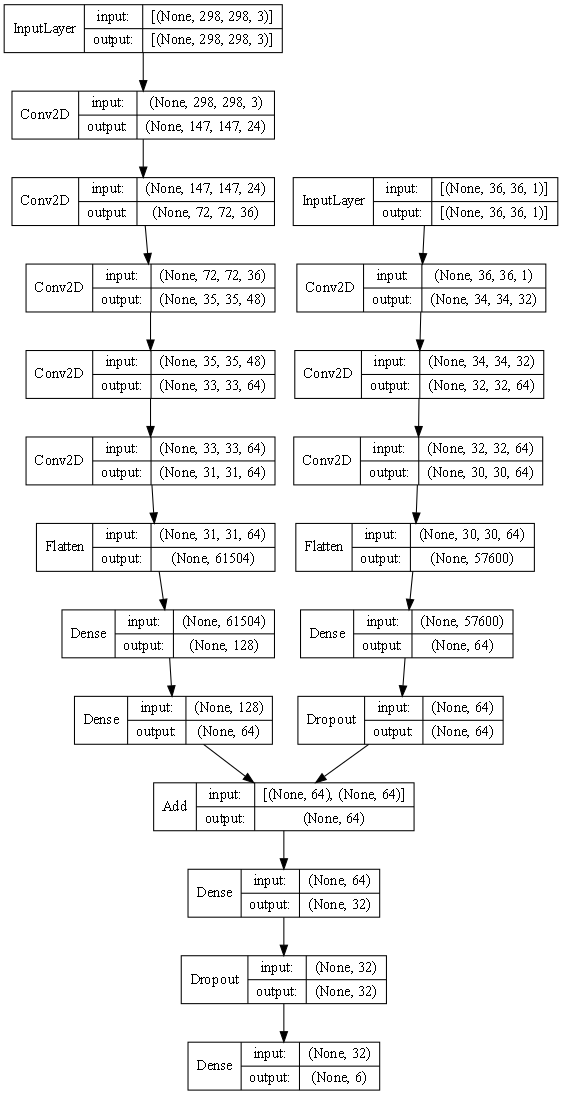

In [140]:
model = duel_image_add_dense_model((299,299,3), (36,36,1), 6, 'adam',None,None,None,None,None, 0, 0, 0, 0.2, 0.2)
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir="TB", expand_nested=True, dpi=75)

In [141]:
model.summary()

Model: "duel_image_add_dense_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_170 (InputLayer)          [(None, 298, 298, 3) 0                                            
__________________________________________________________________________________________________
conv2d_566 (Conv2D)             (None, 147, 147, 24) 1824        input_170[0][0]                  
__________________________________________________________________________________________________
conv2d_567 (Conv2D)             (None, 72, 72, 36)   21636       conv2d_566[0][0]                 
__________________________________________________________________________________________________
input_171 (InputLayer)          [(None, 36, 36, 1)]  0                                            
_________________________________________________________________________

In [183]:
def four_image_add_conv_model(input_shape, im2_ch, im3_ch, classes, optimizer, \
                                 conv_normalization_im1 = None, conv_normalization_im2 = None, \
                                 conv_normalization_im3 = None, conv_normalization_im4 = None, \
                                 conv_normalization_cmb = None, dense_normalization = None, \
                                 conv_dropout_im1=0, conv_dropout_im2=0, conv_dropout_im3=0, conv_dropout_im4=0, \
                                 conv_dropout_cmb=0, dense_dropout=0):
    
    conv_layer_count_im1 = 4
    if isinstance(conv_dropout_im1, numbers.Number):
        conv_dropout_im1 = [conv_dropout_im1] * conv_layer_count_im1
    
    conv_layer_count_im2 = 3
    if isinstance(conv_dropout_im2, numbers.Number):
        conv_dropout_im2 = [conv_dropout_im2] * conv_layer_count_im2
        
    conv_layer_count_im3 = 3
    if isinstance(conv_dropout_im3, numbers.Number):
        conv_dropout_im3 = [conv_dropout_im3] * conv_layer_count_im3
    
    conv_layer_count_im4 = 2
    if isinstance(conv_dropout_im4, numbers.Number):
        conv_dropout_im4 = [conv_dropout_im4] * conv_layer_count_im4
    
    conv_layer_count_cmb = 1
    if isinstance(conv_dropout_cmb, numbers.Number):
        conv_dropout_cmb = [conv_dropout_cmb] * conv_layer_count_cmb
    
    dense_layer_count = 2
    if isinstance(dense_dropout, numbers.Number):
        dense_dropout = [dense_dropout] * dense_layer_count
    
    image_input = keras.Input(shape=input_shape)
    
    x_1 = conv_layer(image_input, 24, (5,5), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[0])
    x_1 = conv_layer(x_1, 32, (5,5), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[1])
    x_1 = conv_layer(x_1, 48, (3,3), (1,1), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[2])
    x_1 = conv_layer(x_1, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[3])
    
    
    second_image_shape = np.append((np.array(x_1.shape[1:3]) + 6)*2 + 3, im2_ch)
    second_image_input = keras.Input(shape=second_image_shape)
    print(f'Second Image Size should be: {second_image_shape}')
    
    x_2 = conv_layer(second_image_input, 24, (5,5), (2,2), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[0])
    x_2 = conv_layer(x_2, 48, (5,5), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[1])
    x_2 = conv_layer(x_2, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[2])
    
    third_image_shape = np.append(np.array(x_1.shape[1:3]) + 10, im3_ch)
    third_image_input = keras.Input(shape=third_image_shape)
    print(f'Third Image Size should be: {third_image_shape}')
    
    x_3 = conv_layer(third_image_input, 24, (5,5), (1,1), 'valid', 'relu', conv_normalization_im3, conv_dropout_im3[0])
    x_3 = conv_layer(x_3, 48, (5,5), (1,1), 'valid', 'relu', conv_normalization_im3, conv_dropout_im3[1])
    x_3 = conv_layer(x_3, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im3, conv_dropout_im3[2])
    
    fourth_image_shape = np.append(np.array(x_1.shape[1:3]) + 4, 1)
    fourth_image_input = keras.Input(shape=fourth_image_shape)
    print(f'Fourth Image Size should be: {fourth_image_shape}')
    
    x_4 = conv_layer(fourth_image_input, 32, (3,3), (1,1), 'valid', 'relu', conv_normalization_im4, conv_dropout_im4[0])
    x_4 = conv_layer(x_4, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im4, conv_dropout_im4[1])
        
    x = tf.keras.layers.Add()([x_1, x_2, x_3, x_4])
    
    x = conv_layer(x, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_cmb, conv_dropout_cmb[0])
    
    x = layers.Flatten()(x)
    
    x = dense_layer(x, 128, 'relu', dense_normalization, dense_dropout[0])
    x = dense_layer(x, 64, 'relu', dense_normalization, dense_dropout[1])
    
    output = layers.Dense(units=classes, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[image_input, second_image_input, third_image_input, fourth_image_input], outputs=output, name="four_image_add_conv_model")
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    
    return model

SyntaxError: unexpected character after line continuation character (<ipython-input-183-d9f0a8d218b6>, line 5)

Second Image Size should be: [101  35   3]
Third Image Size should be: [53 20  1]
Fourth Image Size should be: [47 14  1]


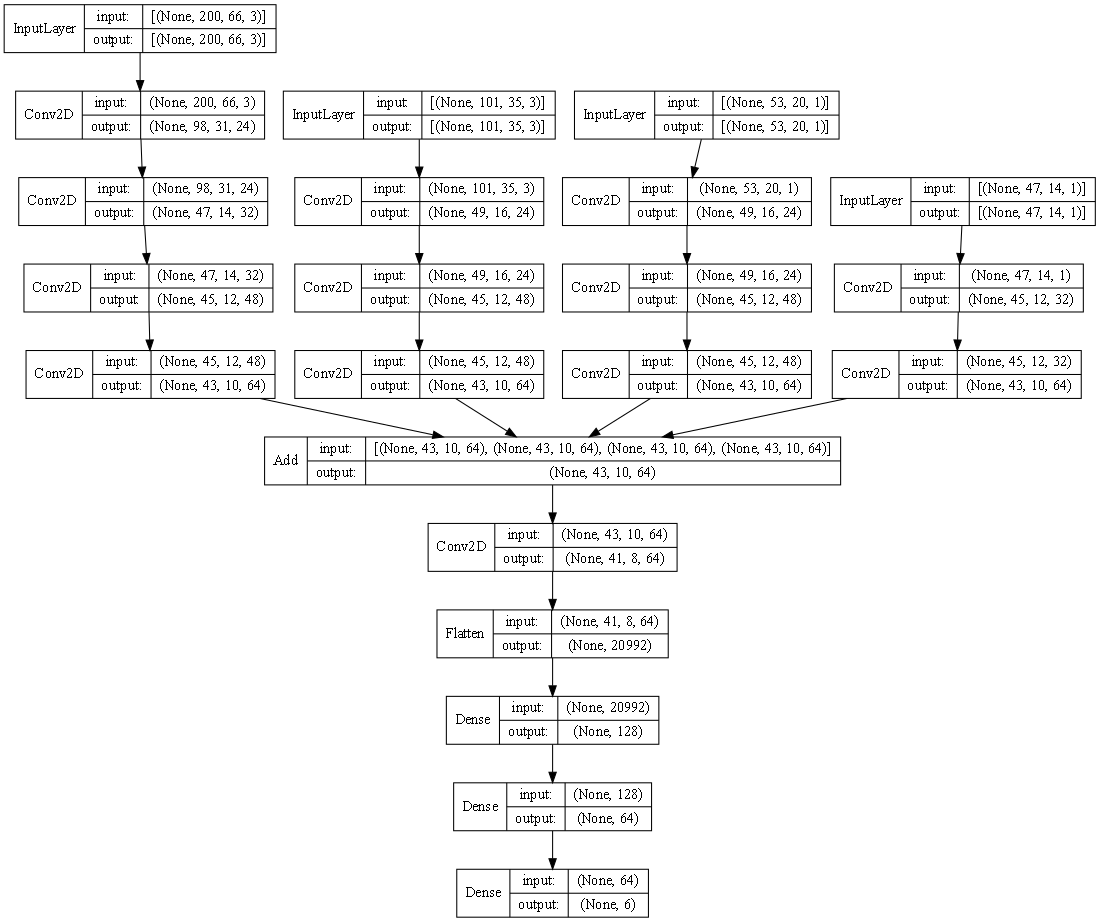

In [184]:
model = four_image_add_conv_model((200,66,3), 3, 1, 6, 'adam')
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir="TB", expand_nested=True, dpi=75)

In [163]:
model.summary()

Model: "four_image_add_conv_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_204 (InputLayer)          [(None, 200, 66, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_678 (Conv2D)             (None, 98, 31, 24)   1824        input_204[0][0]                  
__________________________________________________________________________________________________
input_205 (InputLayer)          [(None, 101, 35, 3)] 0                                            
__________________________________________________________________________________________________
input_206 (InputLayer)          [(None, 53, 20, 1)]  0                                            
__________________________________________________________________________

In [180]:
def four_image_add_dense_model(input_shape_im1, input_shape_im2, input_shape_im3, input_shape_im4, classes, optimizer, \
                                 conv_normalization_im1 = None, conv_normalization_im2 = None, \
                                 conv_normalization_im3 = None, conv_normalization_im4 = None, \
                                 dense_normalization_im1 = None, dense_normalization_im2 = None, \
                                 dense_normalization_cmb = None, conv_dropout_im1=0, conv_dropout_im2=0, \
                                 dense_dropout_im1=0, dense_dropout_im2=0, dense_dropout_cmb=0):
    
    conv_layer_count_im1 = 5
    if isinstance(conv_dropout_im1, numbers.Number):
        conv_dropout_im1 = [conv_dropout_im1] * conv_layer_count_im1
    
    conv_layer_count_im2 = 3
    if isinstance(conv_dropout_im2, numbers.Number):
        conv_dropout_im2 = [conv_dropout_im2] * conv_layer_count_im2
    
    dense_layer_count_im1 = 2
    if isinstance(dense_dropout_im1, numbers.Number):
        dense_dropout_im1 = [dense_dropout_im1] * dense_layer_count_im1
    
    dense_layer_count_im2 = 1
    if isinstance(dense_dropout_im2, numbers.Number):
        dense_dropout_im2 = [dense_dropout_im2] * dense_layer_count_im2
        
    dense_layer_count_cmb = 1
    if isinstance(dense_dropout_cmb, numbers.Number):
        dense_dropout_cmb = [dense_dropout_cmb] * dense_layer_count_cmb
    
    image_input = keras.Input(shape=input_shape_im1)
    
    x_1 = conv_layer(image_input, 24, (5,5), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[0])
    x_1 = conv_layer(x_1, 36, (5,5), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[1])
    x_1 = conv_layer(x_1, 48, (3,3), (2,2), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[2])
    x_1 = conv_layer(x_1, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[3])    
    x_1 = conv_layer(x_1, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[4])
    
    x_1 = layers.Flatten()(x_1)
    x_1 = dense_layer(x_1, 128, 'relu', dense_normalization_im1, dense_dropout_im1[0])
    x_1 = dense_layer(x_1, 64, 'relu', dense_normalization_im1, dense_dropout_im1[1])
    
    second_image_input = keras.Input(shape=input_shape_im2)
    
    x_2 = conv_layer(second_image_input, 24, (5,5), (2,2), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[0])
    x_2 = conv_layer(x_2, 48, (5,5), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[1])
    x_2 = conv_layer(x_2, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[1])
    x_2 = conv_layer(x_2, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im1, conv_dropout_im1[4])
    
    x_2 = layers.Flatten()(x_2)
    x_2 = dense_layer(x_2, 128, 'relu', dense_normalization_im1, dense_dropout_im1[0])
    x_2 = dense_layer(x_2, 64, 'relu', dense_normalization_im1, dense_dropout_im1[1])
    
    third_image_input = keras.Input(shape=input_shape_im3)
    
    x_3 = conv_layer(third_image_input, 24, (5,5), (1,1), 'valid', 'relu', conv_normalization_im3, conv_dropout_im2[0])
    x_3 = conv_layer(x_3, 48, (5,5), (1,1), 'valid', 'relu', conv_normalization_im3, conv_dropout_im2[1])
    x_3 = conv_layer(x_3, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im3, conv_dropout_im2[1])
    x_3 = conv_layer(x_3, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im3, conv_dropout_im1[4])
    
    x_3 = layers.Flatten()(x_3)
    x_3 = dense_layer(x_3, 128, 'relu', dense_normalization_im1, dense_dropout_im1[0])
    x_3 = dense_layer(x_3, 64, 'relu', dense_normalization_im1, dense_dropout_im1[1])
    
    fourth_image_input = keras.Input(shape=input_shape_im4)
    
    x_4 = conv_layer(fourth_image_input, 32, (3,3), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[0])
    x_4 = conv_layer(x_4, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[1])
    x_4 = conv_layer(x_4, 64, (3,3), (1,1), 'valid', 'relu', conv_normalization_im2, conv_dropout_im2[2])
    
    x_4 = layers.Flatten()(x_4)
    x_4 = dense_layer(x_4, 128, 'relu', dense_normalization_im1, dense_dropout_im1[0])
    x_4 = dense_layer(x_4, 64, 'relu', dense_normalization_im2, dense_dropout_im2[0])
    
    x = tf.keras.layers.Add()([x_1, x_2, x_3, x_4])
    
    x = dense_layer(x, 32, 'relu', dense_normalization_cmb, dense_dropout_cmb[0])
    
    output = layers.Dense(units=classes, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[image_input, second_image_input, third_image_input, fourth_image_input], outputs=output, name="four_image_add_dense_model")
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    
    return model

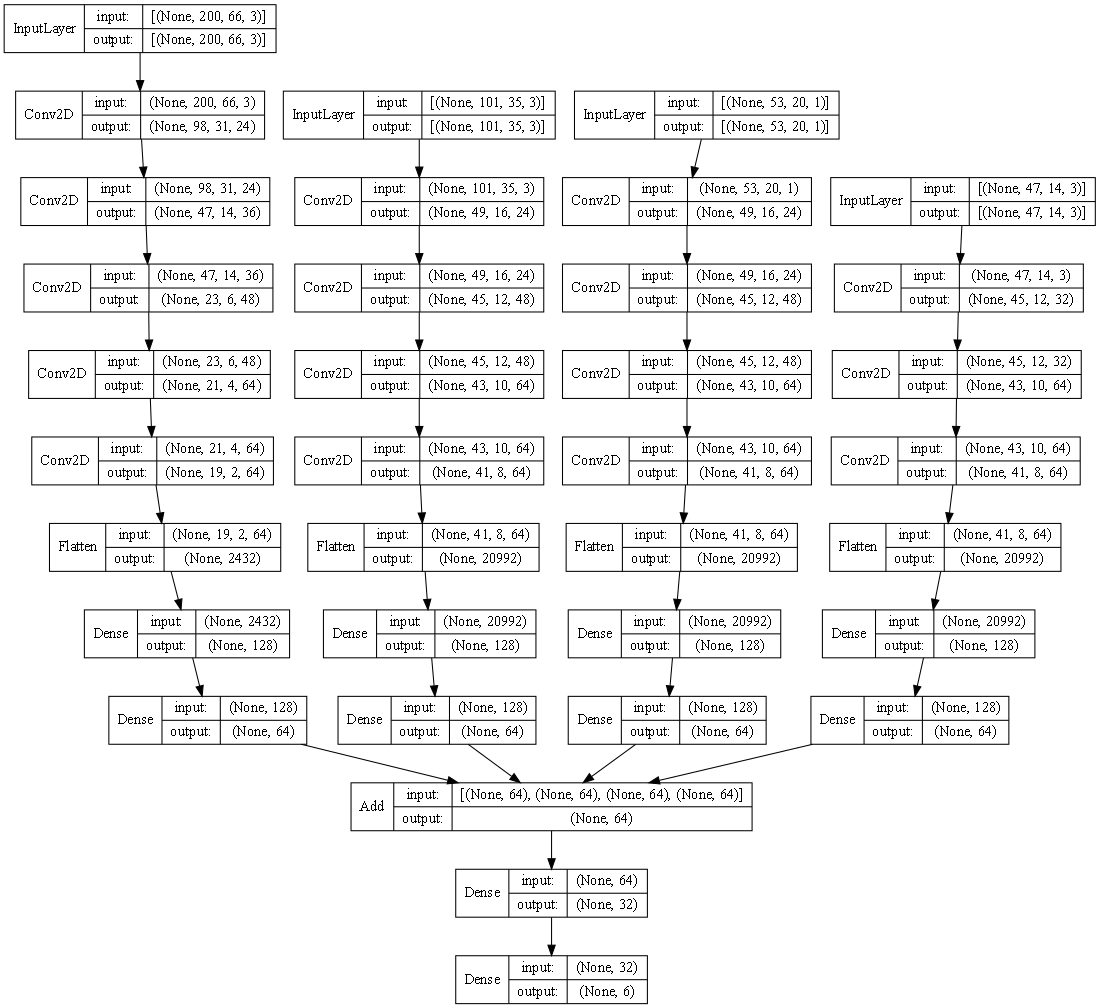

In [181]:
model = four_image_add_dense_model((200,66,3), (101,35,3), (53,20,1), (47,14,3), 6, 'adam')
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir="TB", expand_nested=True, dpi=75)

In [182]:
model.summary()

Model: "duel_image_add_dense_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_227 (InputLayer)          [(None, 200, 66, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_767 (Conv2D)             (None, 98, 31, 24)   1824        input_227[0][0]                  
__________________________________________________________________________________________________
input_228 (InputLayer)          [(None, 101, 35, 3)] 0                                            
__________________________________________________________________________________________________
input_229 (InputLayer)          [(None, 53, 20, 1)]  0                                            
_________________________________________________________________________